# Clasificación rápida en ALeRCE utilizando selección de características y algoritmos genéticos.

Integrantes: Joaquín Cubelli - Tomás de la Sotta

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Ignacio Reyes<br>
Ayudantes: Francisca Cona, Jhon Intriago, Pablo Montero, Óscar Pimentel, Esteban Reyes, Mauricio Romero

El broker astronómico ALeRCE clasifica objetos en tiempo real todas las noches. Para ello utiliza dos modelos, un clasificador basado en estampillas para detección rápida de transientes y un clasificador basado en curvas de luz que utiliza una taxonomía detallada. El clasificador de curvas de luz, descrito en Sánchez-Sáez et al. (2020), consiste en la extracción de múltiples características a partir de las curvas de luz (y otras fuentes de datos) y un modelo basado en Random Forests.

El objetivo de este proyecto es reducir el número de características utilizadas por el clasificador de curvas de luz de ALeRCE, explorando el compromiso entre el desempeño en clasificación y el costo computacional asociado.

La primera etapa del proyecto consiste en **evaluar la estrategia greedy para seleccionar las características más relevantes al momento de clasificar**. En esta estrategia se explorará una característica a la vez, buscando cuál de ellas ayuda más al desempeño del modelo cuando es agregada al conjunto de características utilizadas. También se deberá probar comenzando con todas las características y removiendo una característica a la vez. 

La segunda etapa consiste en **formular el problema como la optimización de una figura de mérito y resolver mediante algoritmos genéticos**. Lo que *se busca minimizar son dos cantidades, el error de clasificación y el tiempo requerido para la clasificación*. Se propone construir una función de fitness que combine ambos costos y luego explorar el frente de Pareto modificando la manera en que se ponderan ambos términos.

Ref: Sánchez-Sáez, P., et al. "Alert Classification for the ALeRCE Broker System: The Light Curve Classifier." arXiv preprint arXiv:2008.03311 (2020).
Ref: Huang, Cheng-Lung, and Chieh-Jen Wang. "A GA-based feature selection and parameters optimization for support vector machines." Expert Systems with applications 31.2 (2006): 231-240. Nota: Tomar como referencia, no como pauta a la cual seguir al pie de la letra. 

Proyecto semestral: https://docs.google.com/document/d/1pz1Yua5fkzJQAhDPjIAwJjJXUPnKswe7gRMs_D2-ixA/edit

Requisitos entrega Intermedia: https://docs.google.com/document/d/1kgTPnFyniYfJPlIaA2JUxTBbzQ6Erax6sKyxXOmG-0Q/edit

Indicaciones proyecto: https://docs.google.com/document/d/10-ZcclkeuGaviFsalC4wnTtrZMiitumQKaUmijk1tsA/edit

Pasos a seguir:
- Dividir los datos en entrenamiento y test (70 %, 30 %), con particionamiento estratificado (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) y normalizar features. Se recomienda QuantileTransformer de scikit-learn. Si el feature no está disponible puede usar un valor -1.0 por ejemplo. Recuerden descartar features baneadas.
- Entrenar un Random Forest balanceado (https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html).
- Reportar métricas de desempeño (Accuracy, F1-score).
- Identificar si existe algún pack de features irrelevantes (i.e. que al sacarlo no cambia el desempeño).
- Implementar estrategia greedy (debe estar corriendo para meeting 2, aunque tal vez no tengan listos los resultados o ambos métodos greedy)

In [1]:
# Correr una vez.

# !pip install --upgrade pip
# !pip install pyarrow
# !pip install -U imbalanced-learn

In [2]:
# Imports:

# Procesamiento de datos.
from pathlib import Path

    #import sys
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

# Tensorflow y asociados.

    #import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
import sklearn.preprocessing as skp

# Resultados

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import cross_validate
    #import itertools
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

## Datos para el Proyecto:

Detecciones: https://droppy.alerce.online/$/LLaeQ

No detecciones: https://droppy.alerce.online/$/PrIbP

Features: https://droppy.alerce.online/$/3x3qh

Etiquetas: https://droppy.alerce.online/$/XHsJO

Abrir con pandas. Algunos archivos tienen formato pickle (o parquet (?) https://arrow.apache.org/docs/python/parquet.html), otros CSV. 
Hay features que no deben usar, como por ejemplo el brillo promedio, ya que no queremos sesgar el análisis según qué tan cerca está el objeto.
Los _1 y _2 de los features indican a qué banda pertenece (banda g, banda r).

In [3]:
# Los features que no deben usar son:

banned_features = [
   'mean_mag_1',
   'mean_mag_2',
   'min_mag_1',
   'min_mag_2',
   'Mean_1',
   'Mean_2',
   'n_det_1',
   'n_det_2',
   'n_pos_1',
   'n_pos_2',
   'n_neg_1',
   'n_neg_2',
   'first_mag_1',
   'first_mag_2',
   'MHPS_non_zero_1',
   'MHPS_non_zero_2',
   'MHPS_PN_flag_1',
   'MHPS_PN_flag_2',
   #'W1', 'W2', 'W3', 'W4',
   'iqr_1',
   'iqr_2',
   'delta_mjd_fid_1',
   'delta_mjd_fid_2',
   'last_mjd_before_fid_1',
   'last_mjd_before_fid_2'#,
   #'g-r_ml',
   #'MHAOV_Period_1', 'MHAOV_Period_2'
]

# Datos comentados no se observaban en detecciones ni en no_detecciones

In [4]:
len(banned_features)

24

En el archivo con las etiquetas hay varias clases. Para el análisis agruparemos algunas clases según el siguiente diccionario (etiqueta original: nueva etiqueta)

In [5]:
# Directorios de datasets
Joaquin = False

if Joaquin:
    etiquetas_dir = "/Users/joaquincubelli/Desktop/Inteligencia Computacional/ALeRCE_data/Etiquetas/dfcrossmatches_prioritized_v7.0.1.csv" # csv
    features_dir = "/Users/joaquincubelli/Desktop/Inteligencia Computacional/ALeRCE_data/storage/ztf_workspace/historic_data_20200916/features_20200916.parquet" # parquet
    # Los siguientes directorios tienen datasets separados en múltiples archivos.
    detections_dir = Path("/Users/joaquincubelli/Desktop/Inteligencia Computacional/ALeRCE_data/detections_with_xmatch/") # parquet
    no_detections_dir = Path("/Users/joaquincubelli/Desktop/Inteligencia Computacional/ALeRCE_data/notdet_with_xmatch/") # parquet

else:
    etiquetas_dir = "/media/dela/1TB/A Universidad/Electrica/VIII Sem/Inteligencia Computacional/AlErCe/dfcrossmatches_prioritized_v7.0.1.csv" # csv
    features_dir = "/media/dela/1TB/A Universidad/Electrica/VIII Sem/Inteligencia Computacional/AlErCe/features/storage/ztf_workspace/historic_data_20200916/features_20200916.parquet" # parquet
    # Los siguientes directorios tienen datasets separados en múltiples archivos.
    detections_dir = Path("/media/dela/1TB/A Universidad/Electrica/VIII Sem/Inteligencia Computacional/AlErCe/detections_with_xmatch/") # parquet
    no_detections_dir = Path("/media/dela/1TB/A Universidad/Electrica/VIII Sem/Inteligencia Computacional/AlErCe/notdet_with_xmatch/") # parquet

### Lectura Etiquetas:

Por lo visto, en este dataset estan los nombres de cada objeto, junto con la clase respectiva, la posición, período, e información adicional de fuente.

Para este problema, no parece ser muy importante el archivo, salvo por la relación entre el nombre y el tipo de clase.

In [6]:
etiquetas = pd.read_csv(etiquetas_dir)
etiquetas

,oid,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec
0,ZTF19abegncu,AGN,357.296363,-8.941186,NaN,Oh2015,5.8772718059579e+17,AGN_galaxy_dominated,0.243081
1,ZTF18acejdhu,AGN,11.958444,-10.496615,NaN,Oh2015,5.877272256953059e+17,AGN_galaxy_dominated,0.301126
2,ZTF18acdzene,AGN,17.478620,-10.110250,NaN,Oh2015,5.877271789938934e+17,AGN_galaxy_dominated,0.158643
3,ZTF18abwzuzw,AGN,25.038255,-10.352430,NaN,Oh2015,5.877272294485526e+17,AGN_galaxy_dominated,0.485322
4,ZTF19abmposz,AGN,26.670031,-8.354787,NaN,Oh2015,5.877271806085038e+17,AGN_galaxy_dominated,0.213990
...,...,...,...,...,...,...,...,...,...
173874,ZTF18abikbvc,LPV,286.720222,24.733440,NaN,GAIADR2VS,4.533629080944307e+18,MIRA_SR,0.299487
173875,ZTF19aamtoyb,LPV,99.257590,-15.567786,NaN,GAIADR2VS,2.9501070744892713e+18,MIRA_SR,0.299597
173876,ZTF19abeesgk,LPV,277.499222,-27.002742,NaN,GAIADR2VS,4.0518162825206625e+18,MIRA_SR,0.299766
173877,ZTF18abnubuy,LPV,292.053754,38.418277,NaN,GAIADR2VS,2.0526959231045647e+18,MIRA_SR,0.299777


In [7]:
etiquetas = etiquetas[['oid','classALeRCE']]

### Lectura Features:

Por lo visto, este es el archivo a revisar, puesto a que tiene los nombres de cada objeto, con cada feature característica.
Sin embargo, en este archivo no aparece la clase de cada objeto, por lo que es necesario relacionar ambas databases para clasificación. 

Recordar que en las instrucciones nos muestran cómo manejar los NaN:
*Si el feature no está disponible puede usar un valor -1.0 por ejemplo. Recuerden descartar features baneadas.*

In [8]:
features = pd.read_parquet(features_dir)

In [9]:
features = features.drop(banned_features, axis=1)

Se asocian los features con las etiquetas

In [10]:
dataset = pd.merge(features, etiquetas, left_on='index', right_on='oid')

In [11]:
dataset = dataset.drop(['oid'], axis=1)

In [12]:
dataset_num = dataset.select_dtypes(include=[np.number])
norm_func = skp.QuantileTransformer(n_quantiles=1000, output_distribution='uniform')
dataset_norm = pd.DataFrame(norm_func.fit_transform(dataset_num))
#dataset_norm = (dataset_num - dataset_num.mean()) / (dataset_num.max() - dataset_num.min())
dataset[dataset_norm.columns] = dataset_norm
dataset = dataset.fillna(-1)

Dict = {
   "AGN": "AGN",
   "Blazar": "Blazar",
   "CV/Nova": "CV/Nova",
   "SNIa": "SNIa",
   "SNIbc": "SNIbc",
   "SNII": "SNII",
   "SNIIn": "SNII",
   "SLSN": "SLSN",
   "EA": "E",
   "EB/EW": "E",
   "DSCT": "DSCT",
   "RRL": "RRL",
   "Ceph": "CEP",
   "LPV": "LPV",
   "Periodic-Other": "Periodic-Other",
   "QSO": "QSO",
   "YSO": "YSO",
   "RSCVn": "Periodic-Other"
 }

dataset = dataset.replace(to_replace = Dict)

ticks = []
for et in dataset['classALeRCE']:
    if et not in ticks:
        ticks.append(et)
print(ticks)

['Periodic-Other', 'E', 'RRL', 'LPV', 'YSO', 'Blazar', 'QSO', 'DSCT', 'SNIa', 'AGN', 'CV/Nova', 'SNIbc', 'SNII', 'CEP', 'NLQSO', 'NLAGN', 'SLSN', 'SNIIb', 'TDE', 'ZZ']


In [13]:
lista = []
for x, y in Dict.items():
    lista.append(y)

In [14]:
classes = set(lista)

In [15]:
len(classes)

15

In [16]:
dataset = dataset[dataset.classALeRCE.isin(classes)]

In [17]:
dataset

,index,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,...,138,139,140,141,142,143,144,145,146,147
0,ZTF17aaabgdt,0.164834,-1.000000,0.762395,-1.000000,1.0,-1.0,0.285714,-1.000000,0.000000,...,-1.000000,-1.000000,0.165666,-1.000000,0.000000,-1.000000,0.497497,-1.000000,0.676176,0.204801
1,ZTF17aaadfsa,0.196974,0.185956,1.000000,1.000000,2.0,1.0,0.405405,0.470588,0.000000,...,-1.000000,-1.000000,0.538038,0.699199,0.000000,0.000000,0.474763,0.558559,0.471972,0.487487
2,ZTF17aaadxdb,0.253045,0.349630,1.000000,1.000000,1.0,1.0,0.500000,0.350000,0.000000,...,-1.000000,-1.000000,0.814314,0.876376,0.000000,0.000000,0.453295,0.488488,0.169670,0.288579
3,ZTF17aaadzlq,2.482923,1.983951,1.000000,1.000000,13.0,14.0,0.531646,0.469925,0.038298,...,-1.000000,-1.000000,0.561562,0.406907,0.000000,0.000000,0.239105,0.225383,0.493994,0.201424
4,ZTF17aaaenfy,0.487668,0.455345,1.000000,1.000000,1.0,1.0,0.344444,0.318182,0.000000,...,0.914002,-1.000000,0.894895,0.829830,0.397397,0.000000,0.638694,0.538802,0.804805,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118464,ZTF20aauowvs,0.111170,0.074701,0.812132,0.893797,1.0,1.0,0.250000,0.263158,0.000000,...,0.406271,0.042922,0.278278,0.281281,0.599600,0.423924,1.000000,1.000000,0.614114,1.000000
118465,ZTF20aawxcal,0.062353,-1.000000,0.965966,-1.000000,1.0,-1.0,0.428571,-1.000000,0.000000,...,0.767614,0.630567,0.743243,0.510511,0.983483,0.997397,0.000000,0.000000,0.993493,0.359359
118466,ZTF20abawiqv,0.033677,-1.000000,0.450214,-1.000000,1.0,-1.0,0.285714,-1.000000,0.000000,...,0.816659,-1.000000,0.184184,-1.000000,0.793293,-1.000000,1.000000,-1.000000,0.976977,0.018801
118467,ZTF20abcxmfu,0.200823,0.146211,0.765089,0.415971,5.0,7.0,0.272727,0.344828,0.000000,...,-1.000000,-1.000000,0.015015,0.000000,0.000000,0.000000,1.000000,1.000000,0.947447,0.258857


### División dataset:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(dataset.select_dtypes(include=[np.number]), dataset['classALeRCE'], test_size=0.33, random_state=42)

### Entrenar Modelo

In [19]:
clf=BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight=None,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)
clf.fit(X_train, y_train)

BalancedRandomForestClassifier(criterion='entropy', n_estimators=500, n_jobs=-1)

In [20]:
y_pred = clf.predict(X_test)

featuresCopy = np.copy(dataset.columns[1:])
featuresCopy = np.delete(featuresCopy, np.where(featuresCopy == 'classALeRCE'))


fI = clf.feature_importances_

fI*100

array([0.47827626, 0.57501246, 0.25102066, 0.16004457, 0.16911927,
       0.24040494, 0.1622123 , 0.09944518, 0.00846252, 0.00643706,
       0.2155331 , 0.18253225, 0.53862588, 0.37750495, 0.46577489,
       0.32978849, 0.70843992, 0.78890498, 0.1811464 , 0.19552789,
       0.14174205, 0.13714374, 0.14428689, 0.14688932, 0.1540275 ,
       0.14665358, 0.15959535, 0.12856768, 0.14426812, 0.12239387,
       0.16816752, 0.16484891, 0.1607067 , 0.13069245, 0.15796868,
       0.19346866, 0.14632835, 0.19079762, 0.18221323, 0.15198389,
       0.16722831, 0.13837413, 0.17300562, 0.14161676, 0.11164046,
       0.12830319, 0.14242793, 0.14434561, 1.15517462, 0.81031826,
       0.3309449 , 0.91718912, 0.41276618, 0.28956703, 0.40827037,
       0.52768204, 0.52647317, 0.41035533, 0.15468971, 0.1656617 ,
       0.49318474, 0.48651529, 0.19681856, 0.29788511, 0.13376805,
       0.14059264, 1.00799849, 0.12410324, 0.09011595, 0.34565302,
       0.32622722, 0.81232731, 0.41219059, 0.34068026, 0.22196

In [21]:
ImportanceRank = []

while not np.all(fI == -1):
    maxArg = np.argmax(fI)
    ImportanceRank.append(featuresCopy[maxArg])
    fI[maxArg] = -1
ImportanceRank

[147,
 'sgscore1',
 'SPM_chi_1',
 98,
 'IAR_phi_1',
 48,
 66,
 'Multiband_period',
 'positive_fraction_2',
 145,
 99,
 'LinearTrend_2',
 'g-r_max',
 144,
 117,
 51,
 'g-r_mean',
 91,
 127,
 'Period_band_1',
 'IAR_phi_2',
 'g-r_max_corr',
 94,
 'SPM_chi_2',
 'GP_DRW_tau_2',
 71,
 95,
 126,
 'SPM_A_1',
 141,
 17,
 124,
 125,
 'n_non_det_after_fid_2',
 'GP_DRW_tau_1',
 'positive_fraction_1',
 'g-r_mean_corr',
 89,
 'SPM_tau_rise_1',
 'SPM_A_2',
 49,
 107,
 'delta_mag_fid_2',
 16,
 'delta_mag_fid_1',
 'Amplitude_2',
 100,
 'SF_ML_amplitude_2',
 1,
 101,
 'SPM_tau_rise_2',
 'ExcessVar_1',
 'Rcs_2',
 0,
 60,
 'MHPS_low_2',
 106,
 'MHPS_ratio_1',
 146,
 'SPM_tau_fall_1',
 13,
 'rb',
 'SPM_gamma_1',
 'Meanvariance_1',
 116,
 55,
 'Meanvariance_2',
 'SPM_gamma_2',
 'Amplitude_1',
 54,
 15,
 52,
 56,
 12,
 'GP_DRW_sigma_1',
 'SPM_t0_1',
 'Std_1',
 69,
 'Std_2',
 113,
 128,
 90,
 102,
 104,
 'MHPS_high_1',
 'Period_band_2',
 'MHPS_ratio_2',
 'MHPS_low_1',
 14,
 'SPM_tau_fall_2',
 112,
 'gal_b',
 

Visualizemos tanto la estructura del árbol (https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c) y de las distintas features, y analizaremos los datos (https://medium.com/@smollaha/imbalanced-data-visualization-and-random-forest-25cbff51f711)

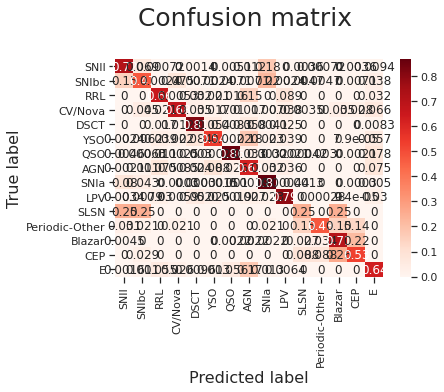

In [22]:
cm = confusion_matrix(y_test, y_pred) 
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(cm, index = classes, columns = classes)

g = sns.heatmap(df, annot=True, cmap="Reds")

g.set_yticklabels(g.get_yticklabels(), rotation = 0)

 #Estandar en 20, 20

plt.title('Confusion matrix \n', size=25)
plt.xlabel('Predicted label', size=16)
plt.ylabel('True label', size=16)

plt.rcParams["figure.figsize"] = (10,10)

In [23]:
scoring = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']

precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average = 'weighted')
accuracy = accuracy_score(y_test, y_pred)


print('Precision: {}  ({}%)'.format(precision, int(precision*100)))
print('Recall:    {}  ({}%)'.format(recall, int(recall*100)))
print('F1-score:  {}  ({}%)'.format(f1, int(f1*100)))
print('Accuracy:  {}  ({}%)'.format(accuracy, int(accuracy*100)))

Precision: 0.8765976938797916  (87%)
Recall:    0.7189084020275459  (71%)
F1-score:  0.7695004700078798  (76%)
Accuracy:  0.7189084020275459  (71%)


# Comentarios Meeting 1

Random Forest de ALeRCE -> https://github.com/alercebroker/lc_classifier/blob/52e147d67ed8fd549bf162c5ec6cdf06c545337a/lc_classifier/classifier/models.py#L56 - **implementado**

Quantile Tranformer para normalizar en vez de normalización de mínimo y máximo. - **listo**

Eliminar clases que aparecen poco o no aparecen en absoluto (ZZ, TDE, etc.) - **listo**

En el Random Forest se puede obtener el Ranking para simplificar la busqueda de features. - **listo**

Ver packs de características (https://docs.google.com/document/d/10-ZcclkeuGaviFsalC4wnTtrZMiitumQKaUmijk1tsA/edit)

Usar matriz de confusión normalizada (Filas suman 1) - **listo**

**Temas faltantes:**
- Incorporar el pack de características
- Implementar estrategia greedy

**Pasos a seguir meeting 3:**
- Tener implementado feature selection greedy basado en la importancia dada por Random Forest. Mostrar curva accuracy vs número de packs y accuracy vs tiempo de cómputo asociado.
- Implementar selección de características con algoritmos genéticos y probarlo. Obtener resultados preliminares y construir curvas para comparar con estrategia greedy. Reportar curvas de fitness vs generaciones con mejor fitness, peor fitness y fitness promedio.
- Revisar material de estudio para entender conceptos básicos de algoritmos genéticos. Si tienen cualquier duda contáctenme.
- Al parecer la librería más popular de computación evolutiva en python es DEAP https://deap.readthedocs.io/en/master/ Siempre pueden implementar la optimización con algoritmos genéticos desde cero, pero es más fácil si se apoyan en una librería.
- Les recomiendo usar para el genotipo una codificación binaria, donde cada bit indica si un pack está presente o no.
- En la función de fitness van a tener que entrenar el RF con los packs indicados por el genotipo y luego calcular el accuracy (o la métrica que elijan para indicar performance de clasificación). Después deberán calcular el costo computacional de los features usados. Finalmente deben construir un puntaje de fitness combinando ambos valores (transformar en un problema mono-objetivo), teniendo cuidado de que las escalas de ambos términos sean comparables para que ambos contribuyan en el proceso de optimización.
